In [41]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA

import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

# Import Dataset

In [ ]:
dataset = pd.read_csv("METABRIC_RNA_Mutation.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (179,189,191,193) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Describing Dataset

In [42]:
dataset.head()

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,neoplasm_histologic_grade,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,hormone_therapy,inferred_menopausal_state,integrative_cluster,oncotree_code,pr_status,radio_therapy,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,cdh1_mut,dnah2_mut,kmt2d_mut,ush2a_mut,ryr2_mut,dnah5_mut,herc2_mut,pde4dip_mut,akap9_mut,tg_mut,birc6_mut,utrn_mut,tbx3_mut,...,hsd17b1,hsd17b10,hsd17b11,hsd17b12,hsd17b13,hsd17b14,hsd17b2,hsd17b3,hsd17b4,hsd17b6,hsd17b7,hsd17b8,hsd3b1,hsd3b2,hsd3b7,mecom,met,ncoa2,nrip1,pik3r3,prkci,prkd1,ran,rdh5,sdc4,serpini1,shbg,slc29a1,sox9,spry2,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
1,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Pre,4ER+,IDC,Positive,1,0,H178P,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.4467,-0.0693,-0.7837,0.0117,1.5355,0.7590,-0.5652,0.0623,-1.2693,1.0729,1.1973,-2.9847,-1.9199,0.6433,-0.4801,-1.8732,-1.0840,-0.7220,-0.1878,-1.0623,1.7653,0.3500,-0.2505,-0.6337,-0.1047,0.0222,-0.2938,-1.0821,-1.3206,0.2446,-0.4412,0.4534,0.4068,0.7634,0.0231,0.9121,-0.9538,-0.2264,0.5398,-0.8920
2,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumB,Positve,Positive,2.0,NEUTRAL,Negative,Ductal/NST,1,Pre,3,IDC,Positive,0,H1047R,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.6253,0.0082,1.6822,0.8981,-0.0943,1.1599,0.1442,0.1493,0.1117,1.6262,2.2685,-0.9910,0.1767,-0.9128,-0.0006,0.7079,-0.7401,1.2279,-0.2882,-0.1727,1.1257,0.8306,0.2707,-0.7554,-0.3559,-0.7735,-0.1387,-0.9122,1.2552,0.4593,-0.5381,0.0668,0.8344,1.7227,0.4024,-3.7172,-1.5538,1.3701,-0.1078,0.3655
3,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,LumB,Positve,Positive,2.0,NEUTRAL,Negative,Mixed,1,Pre,9,MDLC,Positive,1,E542K,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4.8189,0.0960,1.4099,-0.6707,-0.3589,-0.8998,-0.5063,0.2546,-0.6586,1.7024,0.1617,1.4208,0.1320,1.8754,-1.8850,0.1474,0.5097,-0.0393,-0.2049,-0.3290,3.2140,2.4162,1.7962,-1.2505,-0.1742,-0.2858,-0.7305,-1.0178,-0.7887,1.3361,-0.5630,-0.7078,0.8228,0.6819,-0.1948,-2.3286,-0.9924,-0.3154,0.2320,-0.4828
4,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Mixed,1,Post,9,MDLC,Positive,1,0,S241F,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,F2321Y,0,0,0,...,-0.0590,0.2796,0.0493,-0.7074,0.0696,-0.4491,-0.5634,-0.7627,-0.7051,0.6065,-0.0141,0.7040,-2.0938,-0.1260,-0.6658,0.6451,0.5497,4.1999,0.2832,0.4018,0.1308,-0.5351,1.2930,1.2971,-0.8885,-0.5545,0.0266,0.5328,0.1858,-0.3201,-0.5845,-0.3544,-1.0150,2.2961,0.1817,-0.1572,0.0427,5.0048,3.8476,1.3223
5,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,LumB,Positve,Positive,3.0,NEUTRAL,Negative,Ductal/NST,1,Post,7,IDC,Positive,1,H1047R,P67Qfs*56,0,0,0,0,A318T,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,-0.4705,0.0219,0.8457,0.2548,-0.4682,-0.7314,-0.3240,-0.3282,1.1360,1.5011,-0.4428,0.6873,0.1311,-0.4149,-0.9105,-0.8526,-0.7718,0.0466,-0.1657,1.0143,1.3033,1.3506,0.2875,-1.0378,1.1967,-0.3843,0.4306,0.0314,0.6884,-0.4448,-0.3910,0.0395,0.8191,0.1977,-0.2302,-0.5092,-0.3021,0.9357,-0.4217,0.5340


In [ ]:
print(dataset.shape)
dataset.dtypes

(1904, 688)


type_of_breast_surgery          object
cancer_type                     object
cancer_type_detailed            object
cellularity                     object
pam50_+_claudin-low_subtype     object
                                ...   
tnk2                           float64
tulp4                          float64
ugt2b15                        float64
ugt2b17                        float64
ugt2b7                         float64
Length: 688, dtype: object

# Check missing value

In [ ]:
miss_value = {}
for column in dataset.columns:
  count = dataset[column].isnull().sum()
  if count >0:
    miss_value[column] = count

print(miss_value)

{'type_of_breast_surgery': 22, 'cancer_type_detailed': 15, 'cellularity': 54, 'er_status_measured_by_ihc': 30, 'neoplasm_histologic_grade': 72, 'tumor_other_histologic_subtype': 15, 'primary_tumor_laterality': 106, 'oncotree_code': 15, '3-gene_classifier_subtype': 204, 'tumor_stage': 501, 'mutation_count': 45, 'tumor_size': 20}


# Drop missing value

In [ ]:
dataset = dataset.drop(['3-gene_classifier_subtype','tumor_stage','primary_tumor_laterality'],axis='columns')
dataset.shape

(1904, 685)

In [ ]:
dataset = dataset.dropna(axis='rows')
dataset.shape

(1677, 685)

# Create target variable

In [ ]:
y = dataset['overall_survival']
dataset = dataset.drop('overall_survival', axis ='columns')

# Check type of value

In [ ]:
dataset['smarcb1_mut'].value_counts()

0       878
0       798
I28L      1
Name: smarcb1_mut, dtype: int64

In [ ]:
list_cat = []
for column in dataset.columns:
    if column == 'age_at_diagnosis':
      break
    else:
      list_cat.append(column)

In [ ]:
for column in list_cat:
    dataset[column] = dataset[column].replace([0],'0')

In [ ]:
dataset['smarcb1_mut'].value_counts()

0       1676
I28L       1
Name: smarcb1_mut, dtype: int64

# Create clean dataset

In [ ]:
dataset_new = pd.get_dummies(dataset,columns=list_cat)
dataset_new.shape

(1677, 7761)

In [ ]:
dataset_new = dataset_new.astype(np.float16)

# Create feature and label

In [ ]:
x = dataset_new.values
x.shape

(1677, 7761)

In [ ]:
labelencoder= LabelEncoder()
y = labelencoder.fit_transform(y)
y.shape

(1677,)

# Split train and test dataset

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

# Train model

In [ ]:
svclassifier = SVC(kernel='rbf')
svclassifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svclassifier.predict(X_test)

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[155  41]
 [ 61  79]]
              precision    recall  f1-score   support

           0       0.72      0.79      0.75       196
           1       0.66      0.56      0.61       140

    accuracy                           0.70       336
   macro avg       0.69      0.68      0.68       336
weighted avg       0.69      0.70      0.69       336



# Experiment 1: without scaling

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


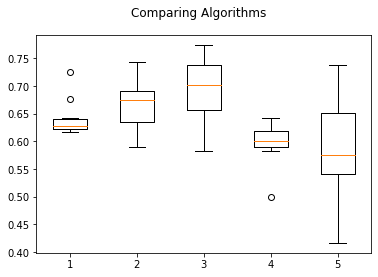

In [ ]:
# keeping all models in one list
models=[]
models.append(('LogisticRegression',LogisticRegression()))
models.append(('knn',KNeighborsClassifier(n_neighbors=5)))
models.append(('SVC',SVC()))
models.append(("decision_tree",DecisionTreeClassifier()))
models.append(('Naive Bayes',GaussianNB()))

# Evaluating Each model
predictions=[]
experiment_1 = {}
error='accuracy'
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x,y,cv=fold,scoring=error)
    predictions.append(result)
    experiment_1[name] = result.mean()

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("Comparing Algorithms")
plt.boxplot(predictions)
plt.show()

In [ ]:

pd.DataFrame([experiment_1])

,LogisticRegression,knn,SVC,decision_tree,Naive Bayes
0,0.642212,0.66841,0.69403,0.596339,0.582007


# Experiment 2: with scaling

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


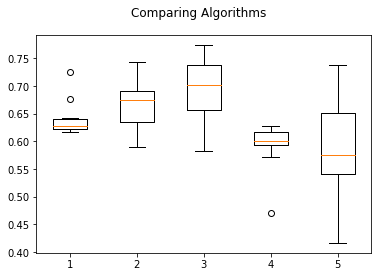

In [ ]:
# Spot Checking and Comparing Algorithms With StandardScaler Scaler
pipelines=[]
pipelines.append(('scaled Logisitic Regression',Pipeline([('scaler',StandardScaler()),('LogisticRegression',LogisticRegression())])))
pipelines.append(('scaled KNN',Pipeline([('scaler',StandardScaler()),('KNN',KNeighborsClassifier(n_neighbors=5))])))
pipelines.append(('scaled SVC',Pipeline([('scaler',StandardScaler()),('SVC',SVC())])))
pipelines.append(('scaled DecisionTree',Pipeline([('scaler',StandardScaler()),('decision',DecisionTreeClassifier())])))
pipelines.append(('scaled naive bayes',Pipeline([('scaler',StandardScaler()),('scaled Naive Bayes',GaussianNB())])))

# Evaluating Each model
predictions=[]
experiment_2 = {}
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x,y,cv=fold,scoring=error)
    predictions.append(result)
    experiment_2[name] = result.mean()

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("Comparing Algorithms")
plt.boxplot(predictions)
plt.show()

In [ ]:
pd.DataFrame([experiment_1, experiment_2])

,LogisticRegression,knn,SVC,decision_tree,Naive Bayes
0,0.642212,0.66841,0.69403,0.596339,0.582007
1,0.642212,0.66841,0.69403,0.591574,0.582007


# Experiment 3: dimensional reduction

In [ ]:
pca = PCA(n_components=500)
new_x = pca.fit_transform(x)

In [ ]:
sum = 0
for i in pca.explained_variance_ratio_:
  sum = sum +i

print("Overall variation :", sum)

Overall variation : 0.992588985266454


In [ ]:
new_x.shape

(1677, 500)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


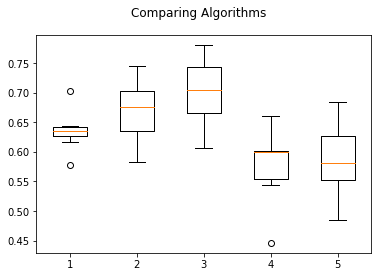

In [ ]:
# Spotcheck and compare algorithms with out applying feature scale.......
n_neighbors=5

# keeping all models in one list
models=[]
models.append(('LogisticRegression',LogisticRegression()))
models.append(('knn',KNeighborsClassifier(n_neighbors=n_neighbors)))
models.append(('SVC',SVC()))
models.append(("decision_tree",DecisionTreeClassifier()))
models.append(('Naive Bayes',GaussianNB()))

# Evaluating Each model
predictions=[]
error='accuracy'
experiment_3 = {}
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,new_x,y,cv=fold,scoring=error)
    predictions.append(result)
    experiment_3[name] = result.mean()

# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("Comparing Algorithms")
plt.boxplot(predictions)
plt.show()

In [ ]:
pd.DataFrame([experiment_1, experiment_2, experiment_3])

,LogisticRegression,knn,SVC,decision_tree,Naive Bayes
0,0.642212,0.66841,0.69403,0.596339,0.582007
1,0.642212,0.66841,0.69403,0.591574,0.582007
2,0.634456,0.66960,0.70119,0.581975,0.587272


# Experiment 4: Autoencoder

In [51]:
from keras.layers import Dense, Dropout
from keras.models import Sequential, Model
from keras import metrics, Input
METRICS = [
    metrics.RootMeanSquaredError(name='rms'),
    metrics.MeanAbsoluteError(name='mae')
]
ENCODING_DIM = 500 #Desired Dimension
BATCH_SIZE = 32
EPOCHS = 50
def make_and_train_autoencoder(X_train, metrics=METRICS):
    
    len_input_output = 7761
    input_ = Input(shape=(len_input_output,))
    encoded = Dense(units=ENCODING_DIM*2, activation="relu")(input_)
    bottleneck = Dense(units=ENCODING_DIM, activation="relu")(encoded)
    decoded = Dense(units=ENCODING_DIM*2, activation="relu")(bottleneck)
    output = Dense(units=len_input_output, activation="linear")(decoded)
    #Training is performed on the entire autoencoder
    autoencoder = Model(inputs=input_, outputs=output)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=[metrics])
    autoencoder.fit(X_train, X_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS)
    #Use only the encoder part for dimensionality reduction
    encoder = Model(inputs=input_, outputs=bottleneck)
    return autoencoder, encoder

In [52]:
autoencoder, encoder = make_and_train_autoencoder(x)

Epoch 1/50
53/53 [==============================] - 9s 170ms/step - loss: 0.2153 - rms: 0.4640 - mae: 0.1685
Epoch 2/50
53/53 [==============================] - 8s 153ms/step - loss: 0.0895 - rms: 0.2991 - mae: 0.0978
Epoch 3/50
53/53 [==============================] - 10s 183ms/step - loss: 0.0643 - rms: 0.2535 - mae: 0.0917
Epoch 4/50
53/53 [==============================] - 9s 173ms/step - loss: 0.0597 - rms: 0.2444 - mae: 0.0918
Epoch 5/50
53/53 [==============================] - 8s 156ms/step - loss: 0.0555 - rms: 0.2355 - mae: 0.0866
Epoch 6/50
53/53 [==============================] - 8s 156ms/step - loss: 0.0522 - rms: 0.2285 - mae: 0.0825
Epoch 7/50
53/53 [==============================] - 9s 161ms/step - loss: 0.0498 - rms: 0.2232 - mae: 0.0790
Epoch 8/50
53/53 [==============================] - 9s 165ms/step - loss: 0.0479 - rms: 0.2189 - mae: 0.0788
Epoch 9/50
53/53 [==============================] - 8s 145ms/step - loss: 0.0457 - rms: 0.2139 - mae: 0.0771
Epoch 10/50
53/53 

In [53]:
x_encoded_data = encoder(x).numpy()

In [54]:
x_encoded_data.shape

(1677, 500)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


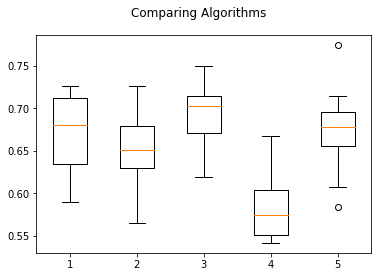

In [55]:
# Spotcheck and compare algorithms with out applying feature scale.......
n_neighbors=5

# keeping all models in one list
models=[]
models.append(('LogisticRegression',LogisticRegression()))
models.append(('knn',KNeighborsClassifier(n_neighbors=n_neighbors)))
models.append(('SVC',SVC()))
models.append(("decision_tree",DecisionTreeClassifier()))
models.append(('Naive Bayes',GaussianNB()))

# Evaluating Each model
predictions=[]
error='accuracy'
experiment_4 = {}
for name,model in models:
    fold=KFold(n_splits=10)
    result=cross_val_score(model,x_encoded_data,y,cv=fold,scoring=error)
    predictions.append(result)
    experiment_4[name] = result.mean()
    
# Visualizing the Model accuracy
fig=plt.figure()
fig.suptitle("Comparing Algorithms")
plt.boxplot(predictions)
plt.show()

In [56]:
pd.DataFrame([experiment_1, experiment_2, experiment_3, experiment_4])

,LogisticRegression,knn,SVC,decision_tree,Naive Bayes
0,0.642212,0.668410,0.694030,0.596339,0.582007
1,0.642212,0.668410,0.694030,0.591574,0.582007
2,0.634456,0.669600,0.701190,0.581975,0.587272
3,0.671429,0.654762,0.695862,0.581373,0.673820
